<a href="https://colab.research.google.com/github/INmais/Energy_Services_2022/blob/main/Energy_Services_2022_Class_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
! pip install requests
! pip install prophet

## Step 1 - import required libraries

In [11]:
#import required libraries

#base
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# for usinng paths
from pathlib import Path

# pattern recognition in TS
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR

# forecasting TS
from prophet import Prophet


Data source: https://mercado.ren.pt/EN/Electr/MarketInfo/MarketResults/OMIE/Pages/Prices.aspx

Period: 01/01/2017 - 15/03/2022

In [105]:
url = 'https://raw.githubusercontent.com/INmais/Energy_Services_2022/main/Data/PrecoMerc%202017-2022.csv'
omie = pd.read_csv(url, sep=';')

In [106]:
omie

,Date,Hour,Session,Price - PT [€/MWh],Price - ES [€/MWh]
0,2017-01-01,1,0,"58,82","58,82"
1,2017-01-01,2,0,"58,23","58,23"
2,2017-01-01,3,0,"51,95","51,95"
3,2017-01-01,4,0,"47,27","47,27"
4,2017-01-01,5,0,"46,90","45,49"
...,...,...,...,...,...
267254,2022-03-15,20,2,"292,03","292,03"
267255,2022-03-15,21,2,"311,71","311,71"
267256,2022-03-15,22,2,"304,19","304,19"
267257,2022-03-15,23,2,"280,17","280,17"


In [107]:
omie['Hour'] = omie['Hour'].astype(str)

Replace ['Hour'] 1-23 to 0:00 23:00

In [109]:
omie['Hour']= omie['Hour'].str.replace(r'\b1\b','01:00',regex=True)
omie['Hour']= omie['Hour'].str.replace(r'\b2\b','02:00',regex=True) 
omie['Hour']= omie['Hour'].str.replace(r'\b3\b','03:00',regex=True) 
omie['Hour']= omie['Hour'].str.replace(r'\b4\b','04:00',regex=True) 
omie['Hour']= omie['Hour'].str.replace(r'\b5\b','05:00',regex=True) 
omie['Hour']= omie['Hour'].str.replace(r'\b6\b','06:00',regex=True) 
omie['Hour']= omie['Hour'].str.replace(r'\b7\b','07:00',regex=True) 
omie['Hour']= omie['Hour'].str.replace(r'\b8\b','08:00',regex=True) 
omie['Hour']= omie['Hour'].str.replace(r'\b9\b','09:00',regex=True) 
omie['Hour']= omie['Hour'].str.replace(r'\b10\b','10:00',regex=True) 
omie['Hour']= omie['Hour'].str.replace(r'\b11\b','11:00',regex=True) 
omie['Hour']= omie['Hour'].str.replace(r'\b12\b','12:00',regex=True) 
omie['Hour']= omie['Hour'].str.replace(r'\b13\b','13:00',regex=True) 
omie['Hour']= omie['Hour'].str.replace(r'\b14\b','14:00',regex=True) 
omie['Hour']= omie['Hour'].str.replace(r'\b15\b','15:00',regex=True) 
omie['Hour']= omie['Hour'].str.replace(r'\b16\b','16:00',regex=True)
omie['Hour']= omie['Hour'].str.replace(r'\b17\b','17:00',regex=True)
omie['Hour']= omie['Hour'].str.replace(r'\b18\b','18:00',regex=True)
omie['Hour']= omie['Hour'].str.replace(r'\b19\b','19:00',regex=True)
omie['Hour']= omie['Hour'].str.replace(r'\b20\b','20:00',regex=True)
omie['Hour']= omie['Hour'].str.replace(r'\b21\b','21:00',regex=True)
omie['Hour']= omie['Hour'].str.replace(r'\b22\b','22:00',regex=True)
omie['Hour']= omie['Hour'].str.replace(r'\b23\b','23:00',regex=True)
omie['Hour']= omie['Hour'].str.replace(r'\b24\b','00:00',regex=True)

In [110]:
omie.head(25)

,Date,Hour,Session,Price - PT [€/MWh],Price - ES [€/MWh]
0,2017-01-01,01:00,0,"58,82","58,82"
1,2017-01-01,02:00,0,"58,23","58,23"
2,2017-01-01,03:00,0,"51,95","51,95"
3,2017-01-01,04:00,0,"47,27","47,27"
4,2017-01-01,05:00,0,"46,90","45,49"
5,2017-01-01,06:00,0,"46,60","44,50"
6,2017-01-01,07:00,0,"46,25","44,50"
7,2017-01-01,08:00,0,"46,10","44,72"
8,2017-01-01,09:00,0,"46,10","44,22"
9,2017-01-01,10:00,0,"45,13","45,13"


In [116]:
omie['Hour'].unique() #seems there is a 25

array(['01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00',
       '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00',
       '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00',
       '22:00', '23:00', '00:00', '25'], dtype=object)

Problem with 25 hour of the day

In [118]:
omie.loc[omie['Hour'] == '25']

,Date,Hour,Session,Price - PT [€/MWh],Price - ES [€/MWh],datetime
40355,2017-10-29,25,0,"48,37","48,37",2017-10-29 25
40380,2017-10-29,25,1,"43,53","43,53",2017-10-29 25
40405,2017-10-29,25,2,"43,87","43,87",2017-10-29 25
40425,2017-10-29,25,3,"43,58","43,58",2017-10-29 25
40442,2017-10-29,25,4,"44,66","44,66",2017-10-29 25
40455,2017-10-29,25,5,"45,00","45,00",2017-10-29 25
40464,2017-10-29,25,6,"46,00","46,00",2017-10-29 25
40467,2017-10-29,25,7,"45,00","45,00",2017-10-29 25
89131,2018-10-28,25,0,"60,00","60,00",2018-10-28 25
89156,2018-10-28,25,1,"54,08","54,08",2018-10-28 25


In [121]:
check = omie.iloc[40355:40467]

In [123]:
check.tail(30)

,Date,Hour,Session,Price - PT [€/MWh],Price - ES [€/MWh],datetime
40437,2017-10-29,20:00,4,"57,27","57,27",2017-10-29 20:00
40438,2017-10-29,21:00,4,"61,30","61,30",2017-10-29 21:00
40439,2017-10-29,22:00,4,"60,65","60,65",2017-10-29 22:00
40440,2017-10-29,23:00,4,"58,14","58,14",2017-10-29 23:00
40441,2017-10-29,00:00,4,"54,46","54,46",2017-10-29 00:00
40442,2017-10-29,25,4,"44,66","44,66",2017-10-29 25
40443,2017-10-29,13:00,5,"40,13","40,13",2017-10-29 13:00
40444,2017-10-29,14:00,5,"42,00","42,00",2017-10-29 14:00
40445,2017-10-29,15:00,5,"40,00","40,00",2017-10-29 15:00
40446,2017-10-29,16:00,5,"43,00","43,00",2017-10-29 16:00


### Second approach

- create a list with 1 to 24
- set that list for the lengh of the dataframe

In [126]:
v = pd.Series([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
omie['Hour'] = np.tile(v, len(omie) // len(v) + 1)[:len(omie)]  

In [129]:
omie['Hour'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

regex: \b \b boudaries means just element with those boudaries

In [131]:
omie['Hour'] = omie['Hour'].astype(str)

In [132]:
omie['Hour']= omie['Hour'].str.replace(r'\b1\b','01:00',regex=True)
omie['Hour']= omie['Hour'].str.replace(r'\b2\b','02:00',regex=True) 
omie['Hour']= omie['Hour'].str.replace(r'\b3\b','03:00',regex=True) 
omie['Hour']= omie['Hour'].str.replace(r'\b4\b','04:00',regex=True) 
omie['Hour']= omie['Hour'].str.replace(r'\b5\b','05:00',regex=True) 
omie['Hour']= omie['Hour'].str.replace(r'\b6\b','06:00',regex=True) 
omie['Hour']= omie['Hour'].str.replace(r'\b7\b','07:00',regex=True) 
omie['Hour']= omie['Hour'].str.replace(r'\b8\b','08:00',regex=True) 
omie['Hour']= omie['Hour'].str.replace(r'\b9\b','09:00',regex=True) 
omie['Hour']= omie['Hour'].str.replace(r'\b10\b','10:00',regex=True) 
omie['Hour']= omie['Hour'].str.replace(r'\b11\b','11:00',regex=True) 
omie['Hour']= omie['Hour'].str.replace(r'\b12\b','12:00',regex=True) 
omie['Hour']= omie['Hour'].str.replace(r'\b13\b','13:00',regex=True) 
omie['Hour']= omie['Hour'].str.replace(r'\b14\b','14:00',regex=True) 
omie['Hour']= omie['Hour'].str.replace(r'\b15\b','15:00',regex=True) 
omie['Hour']= omie['Hour'].str.replace(r'\b16\b','16:00',regex=True)
omie['Hour']= omie['Hour'].str.replace(r'\b17\b','17:00',regex=True)
omie['Hour']= omie['Hour'].str.replace(r'\b18\b','18:00',regex=True)
omie['Hour']= omie['Hour'].str.replace(r'\b19\b','19:00',regex=True)
omie['Hour']= omie['Hour'].str.replace(r'\b20\b','20:00',regex=True)
omie['Hour']= omie['Hour'].str.replace(r'\b21\b','21:00',regex=True)
omie['Hour']= omie['Hour'].str.replace(r'\b22\b','22:00',regex=True)
omie['Hour']= omie['Hour'].str.replace(r'\b23\b','23:00',regex=True)
omie['Hour']= omie['Hour'].str.replace(r'\b24\b','00:00',regex=True)

In [135]:
omie['datetime'] = omie['Date'] + " " + omie['Hour']

In [136]:
omie['datetime'] = pd.to_datetime(omie['datetime'], infer_datetime_format=True)
#omie['datetime'] = pd.to_datetime(omie['datetime'], format='%Y-%m-%d %H:%M')

In [137]:
omie

,Date,Hour,Session,Price - PT [€/MWh],Price - ES [€/MWh],datetime,NewCol
0,2017-01-01,01:00,0,"58,82","58,82",2017-01-01 01:00:00,1
1,2017-01-01,02:00,0,"58,23","58,23",2017-01-01 02:00:00,2
2,2017-01-01,03:00,0,"51,95","51,95",2017-01-01 03:00:00,3
3,2017-01-01,04:00,0,"47,27","47,27",2017-01-01 04:00:00,4
4,2017-01-01,05:00,0,"46,90","45,49",2017-01-01 05:00:00,5
...,...,...,...,...,...,...,...
267254,2022-03-15,15:00,2,"292,03","292,03",2022-03-15 15:00:00,15
267255,2022-03-15,16:00,2,"311,71","311,71",2022-03-15 16:00:00,16
267256,2022-03-15,17:00,2,"304,19","304,19",2022-03-15 17:00:00,17
267257,2022-03-15,18:00,2,"280,17","280,17",2022-03-15 18:00:00,18


In [138]:
omie = omie.set_index('datetime')

In [139]:
omie

,Date,Hour,Session,Price - PT [€/MWh],Price - ES [€/MWh],NewCol
datetime,,,,,,
2017-01-01 01:00:00,2017-01-01,01:00,0,"58,82","58,82",1
2017-01-01 02:00:00,2017-01-01,02:00,0,"58,23","58,23",2
2017-01-01 03:00:00,2017-01-01,03:00,0,"51,95","51,95",3
2017-01-01 04:00:00,2017-01-01,04:00,0,"47,27","47,27",4
2017-01-01 05:00:00,2017-01-01,05:00,0,"46,90","45,49",5
...,...,...,...,...,...,...
2022-03-15 15:00:00,2022-03-15,15:00,2,"292,03","292,03",15
2022-03-15 16:00:00,2022-03-15,16:00,2,"311,71","311,71",16
2022-03-15 17:00:00,2022-03-15,17:00,2,"304,19","304,19",17


In [140]:
omie_final = omie[['Price - PT [€/MWh]','Price - ES [€/MWh]']]

In [141]:
omie_final

,Price - PT [€/MWh],Price - ES [€/MWh]
datetime,,
2017-01-01 01:00:00,"58,82","58,82"
2017-01-01 02:00:00,"58,23","58,23"
2017-01-01 03:00:00,"51,95","51,95"
2017-01-01 04:00:00,"47,27","47,27"
2017-01-01 05:00:00,"46,90","45,49"
...,...,...
2022-03-15 15:00:00,"292,03","292,03"
2022-03-15 16:00:00,"311,71","311,71"
2022-03-15 17:00:00,"304,19","304,19"


In [144]:
omie_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 267259 entries, 2017-01-01 01:00:00 to 2022-03-15 19:00:00
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Price - PT [€/MWh]  267259 non-null  object
 1   Price - ES [€/MWh]  267259 non-null  object
dtypes: object(2)
memory usage: 6.1+ MB


In [153]:
omie_final['Price - PT [€/MWh]'] = omie_final['Price - PT [€/MWh]'].str.replace(',','.')
omie_final['Price - ES [€/MWh]'] = omie_final['Price - ES [€/MWh]'].str.replace(',','.')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [154]:
omie_final['Price - ES [€/MWh]']

datetime
2017-01-01 01:00:00     58.82
2017-01-01 02:00:00     58.23
2017-01-01 03:00:00     51.95
2017-01-01 04:00:00     47.27
2017-01-01 05:00:00     45.49
                        ...  
2022-03-15 15:00:00    292.03
2022-03-15 16:00:00    311.71
2022-03-15 17:00:00    304.19
2022-03-15 18:00:00    280.17
2022-03-15 19:00:00    258.12
Name: Price - ES [€/MWh], Length: 267259, dtype: object

In [155]:
omie_final['Price - PT [€/MWh]'] = omie_final['Price - PT [€/MWh]'].astype(float)
omie_final['Price - ES [€/MWh]'] = omie_final['Price - ES [€/MWh]'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0, 0.5, '%')

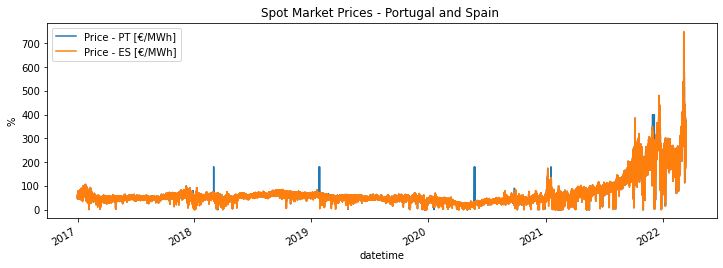

In [158]:
omie_final.plot(figsize=(12,4))
plt.title('Spot Market Prices - Portugal and Spain ')
plt.ylabel('%')

In [169]:
omie_final.describe()

,Price - PT [€/MWh],Price - ES [€/MWh]
count,267259.000000,267259.000000
mean,68.593259,68.468632
std,57.708111,57.757879
min,0.000000,0.000000
25%,41.370000,41.270000
50%,52.190000,52.140000
75%,67.360000,67.370000
max,686.000000,750.000000


## Time Series Decomposition


The frequency of decomposition must be an interval, which 'may' repeat. So we have data with 1 hour frequency and we are looking for a weekly repetition of behavior.

$decompfreq = \cfrac{24h\cdot 1h}{1h} \cdot 7days$


In [166]:
omie_final.index.size/168

1590.827380952381

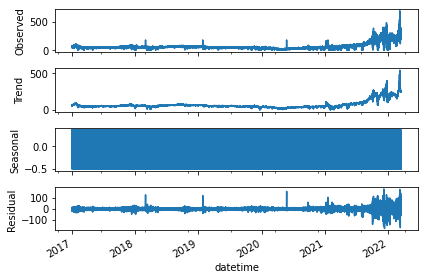

In [168]:
decompfreq = 168 

res = sm.tsa.seasonal_decompose(omie_final['Price - PT [€/MWh]'].interpolate(),
                                freq=decompfreq,
                                model='additive')
resplot = res.plot()
resplot.savefig('Seasonal_Decompose.png', dpi=150)

# Forecasting time series

forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. 

url: https://facebook.github.io/prophet/

In [184]:
import pandas as pd
from prophet import Prophet

The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [185]:
omie_fb = omie[['Price - PT [€/MWh]']]

In [186]:
omie_fb.reset_index(inplace=True)

In [187]:
omie_fb = omie_fb.rename(columns={'datetime': 'ds', 'Price - PT [€/MWh]': 'y'})

In [188]:
omie_fb['y'] = omie_fb['y'].str.replace(',','.')

In [189]:
omie_fb

,ds,y
0,2017-01-01 01:00:00,58.82
1,2017-01-01 02:00:00,58.23
2,2017-01-01 03:00:00,51.95
3,2017-01-01 04:00:00,47.27
4,2017-01-01 05:00:00,46.90
...,...,...
267254,2022-03-15 15:00:00,292.03
267255,2022-03-15 16:00:00,311.71
267256,2022-03-15 17:00:00,304.19
267257,2022-03-15 18:00:00,280.17


Takes a while (this case 13 mn)

In [190]:
m = Prophet()
m.fit(omie_fb)

In [191]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
45960,2023-03-11 23:00:00
45961,2023-03-12 23:00:00
45962,2023-03-13 23:00:00
45963,2023-03-14 23:00:00
45964,2023-03-15 23:00:00


In [192]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
45960,2023-03-11 23:00:00,522.282175,-106.867689,1150.643036
45961,2023-03-12 23:00:00,525.223494,-108.826135,1150.719011
45962,2023-03-13 23:00:00,532.475930,-99.630524,1151.644150
45963,2023-03-14 23:00:00,532.473285,-109.988928,1164.241116
45964,2023-03-15 23:00:00,533.590332,-104.132682,1165.355799


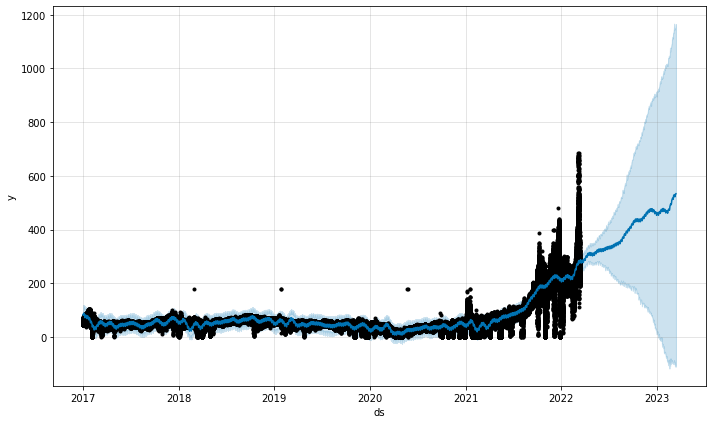

In [193]:
fig1 = m.plot(forecast)


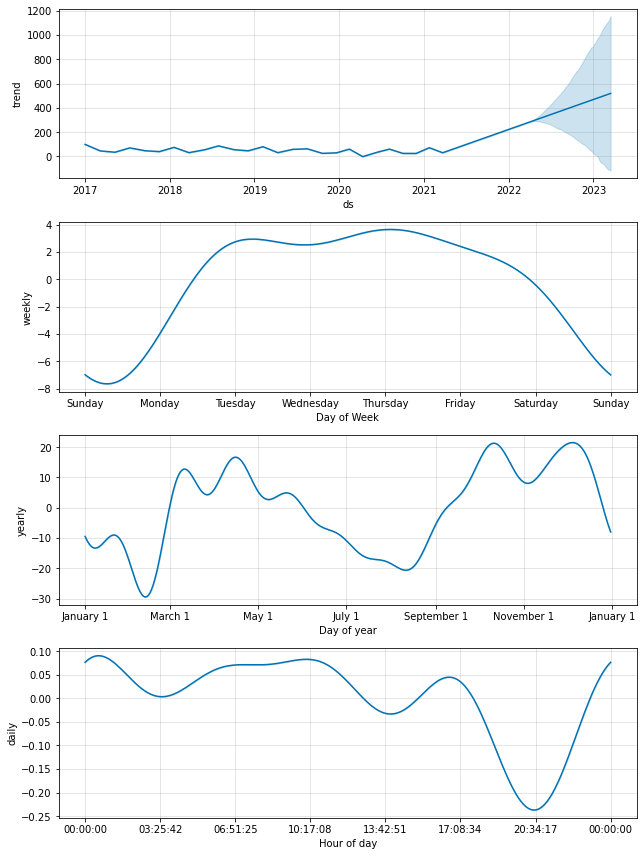

In [194]:
fig2 = m.plot_components(forecast)
